# User config

In [48]:
# Choose one from the `protein_names`
protein_names = ['edF106', '1fb0']
#protein_name = "1fb0"        # The original
#protein_name = "dF106"       # The st functional, \w structure
protein_name = "edF106"      # The 1st enhanced
#protein_name = "MM9"         # The 2nd enhanced
#protein_name = "eMM9"        # The 3rd enhanced

if protein_name == "1fb0":
    gmma_path = '../input/GMMA/trx_gmma.xlsx'
    file_path_esmif = '../data/ESM_results/ESM-IF/AF2_config/1fb0/1FB0/single_sequence/1fb0_results.txt'
    file_path_esm1b = '../data/ESM_results/ESM-1b/1fb0_results.txt'
elif protein_name == "dF106":
    gmma_path = '../input/GMMA/trx_gmma.xlsx'
    file_path_esmif = '../data/ESM_results/ESM-IF/AF2_config/dF106/5J7D/single_sequence/dF106_results.txt'
    file_path_esm1b = '../data/ESM_results/ESM-1b/dF106_results.txt'
elif protein_name == "edF106":
    gmma_path = '../input/GMMA/trx_gmma.xlsx'
    file_path_esmif = '../data/ESM_results/ESM-IF/AF2_config/edF106/5J7D/single_sequence/dF106_results.txt'
    file_path_esm1b = '../data/ESM_results/ESM-1b/edF106_results.txt'
elif protein_name == "MM9":
    gmma_path = '../input/GMMA/trx_gmma.xlsx'
    file_path_esmif = '../data/ESM_results/ESM-IF/AF2_config/MM9/5J7D/single_sequence/dF106_results.txt'
    file_path_esm1b = '../data/ESM_results/ESM-1b/MM9_results.txt'
elif protein_name == "eMM9":
    gmma_path = '../input/GMMA/trx_gmma.xlsx'
    file_path_esmif = '../data/ESM_results/ESM-IF/AF2_config/eMM9/5J7D/single_sequence/dF106_results.txt'
    file_path_esm1b = '../data/ESM_results/ESM-1b/eMM9_results.txt'


# Load data

In [49]:
import pandas as pd

def load_GMMA(file_path):
    # Load the Excel file
    df_GMMA = pd.read_excel(file_path, sheet_name='subst')

    list_from = []
    list_position = []
    list_to = []
    for item in df_GMMA['s']:
        list_from    .append(item[   0])
        list_to      .append(item[  -1])
        list_position.append(item[1:-1])

    # Split the 's' column into 'from', 'position', and 'to'
    df_GMMA['from'    ] = list_from
    df_GMMA['to'      ] = list_to
    df_GMMA['position'] = list_position

    print(f"Rows before filtering step: {df_GMMA.shape}")

    # Filter out rows with invalid 'to' amino acids
    df_GMMA = df_GMMA[df_GMMA['to'].apply(lambda x: x.isalpha())]

    print(f"Rows after 'to' filter: {df_GMMA.shape}")

    # Filter out rows with invalid 'rank'
    df_GMMA = df_GMMA[~df_GMMA['rank'].isna()]

    print(f"Rows after 'rank' NA filter: {df_GMMA.shape}")

    # Convert 'position' to integer
    df_GMMA['position'] = df_GMMA['position'].astype(int)

    # Let only rows where GMMA is in state "use"
    df_GMMA = df_GMMA[df_GMMA['gmma']=='use']

    # Keep only the necessary columns and reorder them
    df_GMMA = df_GMMA[['from', 'position', 'to', 'ddG_glob']]

    return df_GMMA

df_GMMA = load_GMMA('../input/GMMA/trx_gmma.xlsx')

Rows before filtering step: (838, 30)
Rows after 'to' filter: (797, 30)
Rows after 'rank' NA filter: (293, 30)


In [50]:
def load_esm_file(file_path, score_suffix):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    data = []
    for line in lines:
        if not line.startswith('#') and len(line.strip()) > 0 and line != "variant masked-marginals\n":
            #print(line)
            parts = line.split()
            variant = parts[0]
            score = float(parts[1])
            from_aa, position, to_aa = variant[0], int(variant[1:-1]), variant[-1]
            data.append([from_aa, position, to_aa, score])
    
    df = pd.DataFrame(data, columns=['from', 'position', 'to', 'score'+score_suffix])
    return df

# Load the ESM-IF file
df_ESMIF = load_esm_file(file_path_esmif, score_suffix='_ESMIF')

# Load the ESM-1b file
df_ESM1b = load_esm_file(file_path_esm1b, score_suffix='_ESM1b')

In [51]:
# Merge the dataframes on 'from', 'position', and 'to'
df_merged = df_GMMA.merge(df_ESMIF, on=['from', 'position', 'to'])
df_merged = df_merged.merge(df_ESM1b, on=['from', 'position', 'to'])

df_ESM_merged = df_ESMIF.merge(df_ESM1b, on=['from', 'position', 'to'])

# Make plots

## GMMA vs. ESM-IF vs. ESM-1b
Only variants included in GMMA

In [52]:
from scipy.stats import pearsonr

# Compute Pearson correlation coefficients
corr_GMMA_ESMIF = pearsonr(df_merged['ddG_glob'], df_merged['score_ESMIF'])
corr_GMMA_ESM1b = pearsonr(df_merged['ddG_glob'], df_merged['score_ESM1b'])
corr_ESMIF_ESM1b = pearsonr(df_merged['score_ESMIF'], df_merged['score_ESM1b'])

print(f"Pearson's `r` for GMMA vs. ESM-IF: {corr_GMMA_ESMIF.correlation}")
print(f"Pearson's `r` for GMMA vs. ESM-1b: {corr_GMMA_ESM1b.correlation}")
print(f"Pearson's `r` for ESM-IF vs. ESM-1b: {corr_ESMIF_ESM1b.correlation}")

print(f"{len(df_merged)} substitutions were taken into an account.")

Pearson's `r` for GMMA vs. ESM-IF: -0.6004826227868724
Pearson's `r` for GMMA vs. ESM-1b: -0.6916995788598993
Pearson's `r` for ESM-IF vs. ESM-1b: 0.6578298748156762
287 substitutions were taken into an account.


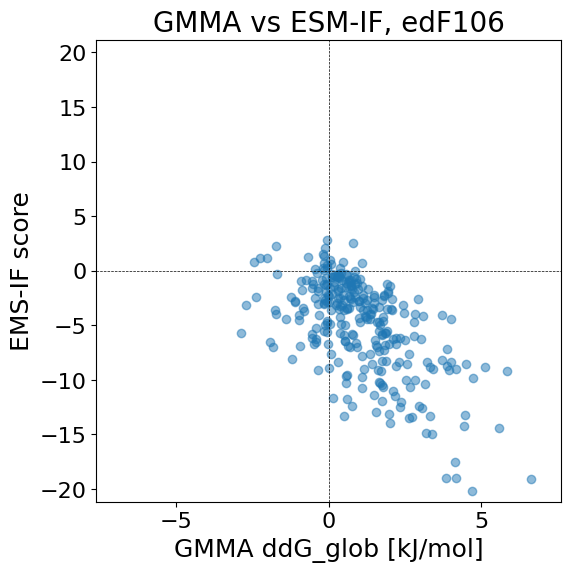

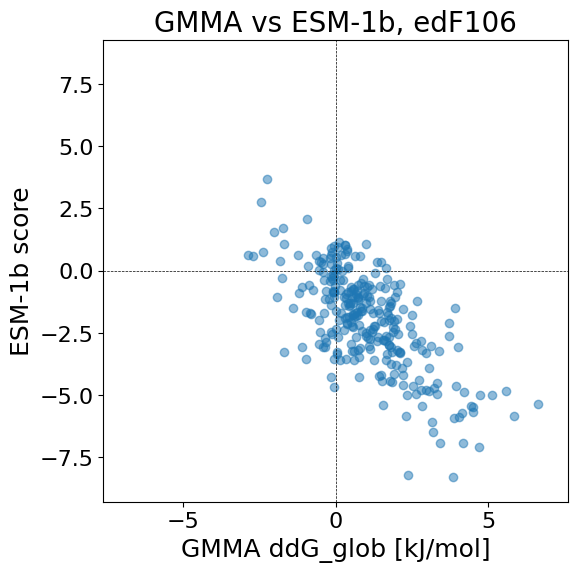

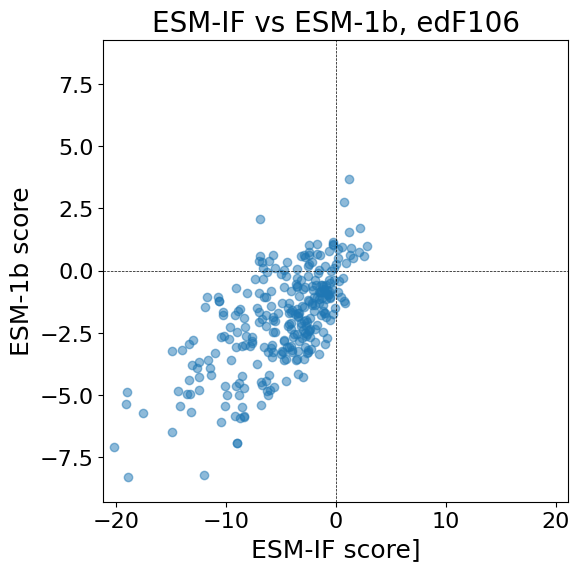

In [53]:
import matplotlib.pyplot as plt
import numpy as np

def plot_score_vs_score(score_x1, score_y1, label_x, label_y, title, saveas="../results/plot.png", score_x2=None, score_y2=None, plot_core=False):
    # Create scatter plots for the intersecting variants
    title_size = 20
    label_size = 18
    tick_size = 16

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    min_x, min_y = score_x1.min(), score_y1.min()
    max_x, max_y = score_x1.max(), score_y1.max()

    # GMMA vs ESM-IF
    ax.scatter(score_x1, score_y1, alpha=0.5)
    if (plot_core):
        ax.scatter(score_x2, score_y2, color="red", alpha=0.5)
        min_x, min_y = np.min([min_x, score_x2.min()]), np.min([min_y, score_y2.min()])
        max_x, max_y = np.min([max_x, score_x2.max()]), np.max([max_y, score_y2.max()])

    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

    x_lim = np.max([np.abs(min_x), np.abs(max_x)])+1
    y_lim = np.max([np.abs(min_y), np.abs(max_y)])+1

    ax.set_xlim(-x_lim, x_lim)
    ax.set_ylim(-y_lim, y_lim)

    ax.set_xlabel(label_x, fontsize=label_size)
    ax.set_ylabel(label_y, fontsize=label_size)
    ax.set_title(title, fontsize=title_size)
    plt.tick_params(axis='both', labelsize=tick_size)

    plt.savefig(saveas)

# GMMA vs. ESM-IF
plot_score_vs_score(
    score_x1=df_merged['ddG_glob'],
    score_y1=df_merged['score_ESMIF'],
    label_x='GMMA ddG_glob [kJ/mol]',
    label_y='EMS-IF score',
    title=f"GMMA vs ESM-IF, {protein_name}",
    saveas=f"../results/scatter_GMMA_ESMIF_{protein_name}.png",
)

# GMMA vs ESM-1b
plot_score_vs_score(
    score_x1=df_merged['ddG_glob'],
    score_y1=df_merged['score_ESM1b'],
    label_x='GMMA ddG_glob [kJ/mol]',
    label_y='ESM-1b score',
    title=f"GMMA vs ESM-1b, {protein_name}",
    saveas=f"../results/scatter_GMMA_ESM1b_{protein_name}.png"
)


# ESM-IF vs ESM-1b
plot_score_vs_score(
    score_x1=df_merged['score_ESMIF'],
    score_y1=df_merged['score_ESM1b'],
    label_x='ESM-IF score]',
    label_y='ESM-1b score',
    title=f"ESM-IF vs ESM-1b, {protein_name}",
    saveas=f"../results/scatter_ESMIF_ESM1b_{protein_name}.png"
)

## ESM-IF vs. ESM-1b
(Plus the active site not inc. in GMMA)

In [54]:
#active_site=[23, 24, 25, 26, 27, 28, 29, 30]
active_site=[25, 26, 27, 28, 29, 30]
df_ESM_active_site = df_ESM_merged[df_ESM_merged['position'].isin(active_site)]
df_ESM_the_rest    = df_ESM_merged[~df_ESM_merged['position'].isin(active_site)]

In [55]:
from scipy.stats import pearsonr

# Compute Pearson correlation coefficients
corr_IF_1b_active_site = pearsonr(df_ESM_active_site['score_ESM1b'], df_ESM_active_site['score_ESMIF'])
corr_IF_1b_non_active_site = pearsonr(df_ESM_the_rest['score_ESM1b'], df_ESM_the_rest['score_ESMIF'])
corr_IF_1b_all = pearsonr(df_ESM_merged['score_ESM1b'], df_ESM_merged['score_ESMIF'])

print(f"Pearson's `r` for ESM-IF vs. ESM-1b: {corr_IF_1b_active_site.correlation}")
print(f"Pearson's `r` for ESM-IF vs. ESM-1b: {corr_IF_1b_non_active_site.correlation}")
print(f"Pearson's `r` for ESM-IF vs. ESM-1b: {corr_IF_1b_all.correlation}")

Pearson's `r` for ESM-IF vs. ESM-1b: 0.5558345765377357
Pearson's `r` for ESM-IF vs. ESM-1b: 0.710786187467586
Pearson's `r` for ESM-IF vs. ESM-1b: 0.7149896920793363


In [56]:
#import plotly.express as px
#
#fig = px.scatter(df_merged, x="score_ESMIF", y="score_ESM1b",
#                 #color="species",
#                 #size='petal_length',
#                 hover_data=['position', 'from', 'to'])
#fig.show()

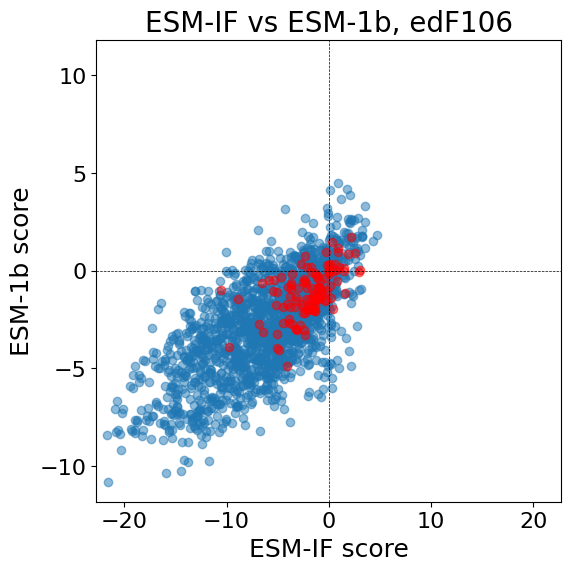

In [57]:

## Create scatter plots for the intersecting variants
#fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#
## ESM-IF vs ESM-1b (all)
#ax.scatter(df_ESM_the_rest['score_ESMIF'], df_ESM_the_rest['score_ESM1b'], color=None, alpha=0.5)
#ax.scatter(df_ESM_active_site['score_ESMIF'], df_ESM_active_site['score_ESM1b'], color='red', alpha=0.5)
#ax.set_xlabel('ESM-IF score')
#ax.set_ylabel('ESM-1b score')
#ax.set_title(f"ESM-IF vs ESM-1b, {protein_name}")

plot_score_vs_score(
    score_x1=df_ESM_the_rest['score_ESMIF'],
    score_y1=df_ESM_the_rest['score_ESM1b'],
    score_x2=df_ESM_active_site['score_ESMIF'],
    score_y2=df_ESM_active_site['score_ESM1b'],
    label_x='ESM-IF score',
    label_y='ESM-1b score',
    title=f"ESM-IF vs ESM-1b, {protein_name}",
    saveas=f"../results/{protein_name}_ESM_active_site.png",
    plot_core=True,
)
